# etape 5 - challenge Telnet

## analyse sur Wireshark
Dans cette analyse, nous explorons une capture réseau réalisée à l'aide de Wireshark portant sur un échange TELNET. Le fichier analysé est telnet-total.pcapng.  
Lorsqu’un client se connecte à un serveur via Telnet, une session TCP s’ouvre du client vers le serveur sur le port 23.  
Contrairement à FTP, l'intégralité de l'échange Telnet se fait sur une seule connexion.  
Pour observer uniquement cet échange, nous appliquons le filtre `tcp.port eq 23`, qui permet de visualiser tous les échanges de la session Telnet.  


## Déroulement de la session telnet  
### 1. Établissement de la connexion  
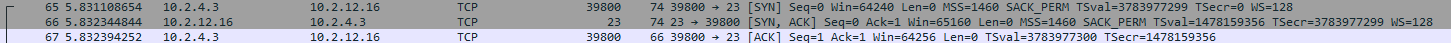
Une connexion TCP est établie entre le client (10.2.4.3, port 39800) et le serveur (10.2.12.16, port 23). Le processus suit le schéma classique du "3-Way Handshake".  
Chaque échange suivant est accompagné d’un acquittement (ACK) sans données, ou bien, si une réponse est envoyée immédiatement, le flag ACK est intégré dans le même paquet que les données (piggybacking). Par exemple, cela se produit lorsque le client tape une lettre sur son clavier et que le serveur l’affiche en retour (echo).
### 2. Séquence de négociation Telnet  
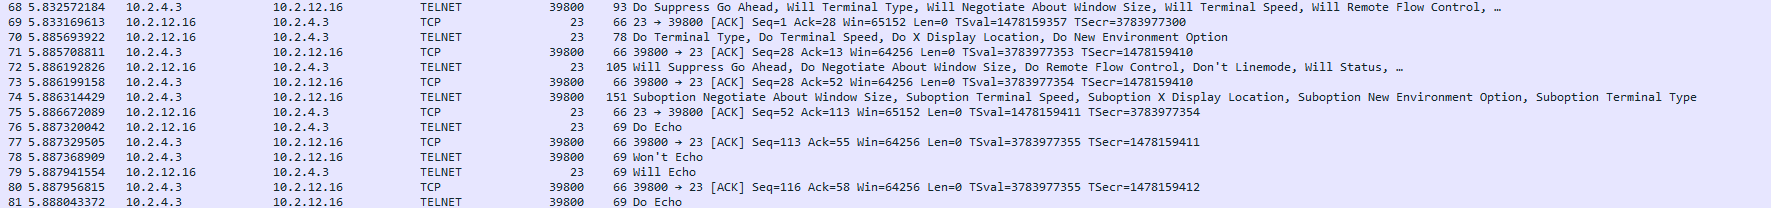
Le serveur envoie des caractères spécifiques, interprétés comme des commandes par le client Telnet (et par le serveur).  
Les principales informations échangées concernent l’écho, la taille de fenêtre, le type de terminal, la gestion des couleurs (xterm-256color) et la vitesse de transmission (baud rate).  
### 3. echange normal entre l'utilisateur et le serveur
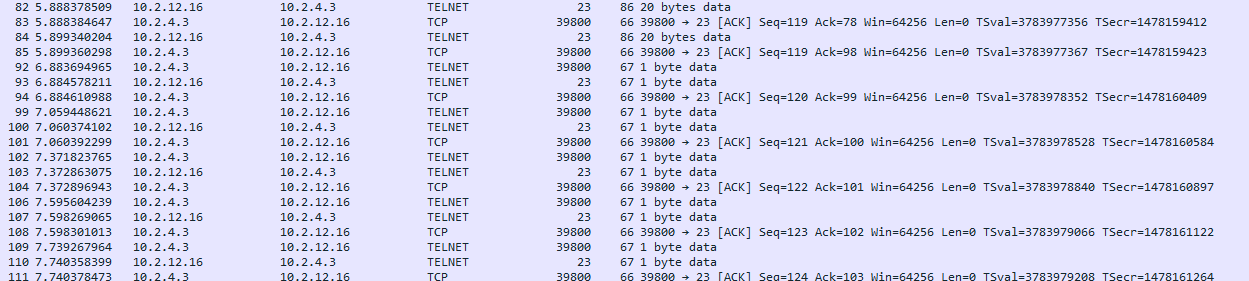  
[...]  
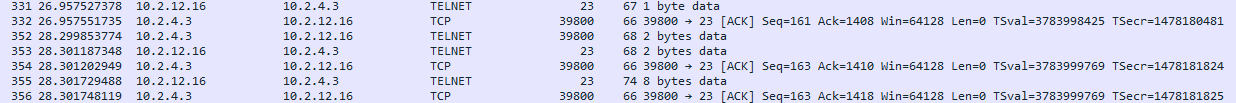  
Suit ensuite l’échange classique entre l’utilisateur et le serveur. Les frappes clavier sont envoyées au serveur, qui renvoie du texte à afficher à l’écran.  
### 4. fin de connection
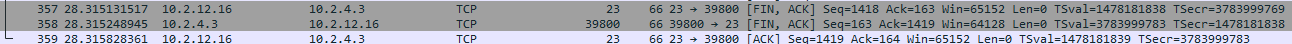  
Enfin, lorsque l’utilisateur tape la commande `exit`, une séquence d’échange FIN/ACK permet de fermer proprement la connexion TCP.  

## extraction des identifiant via wireshark
Comme pour le challenge FTP, il suffit de suivre le flux TCP :   
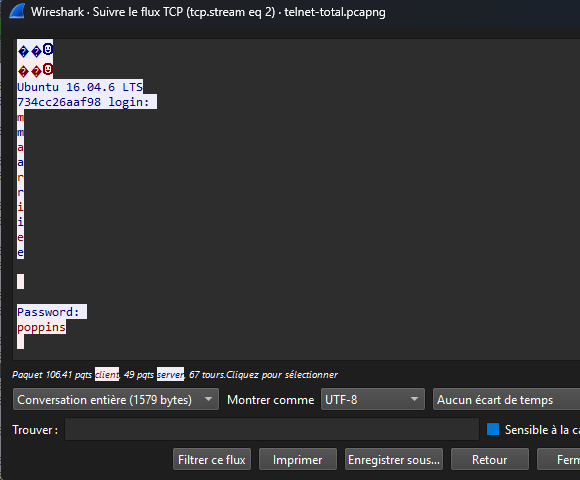  
Le noms d'utilisateur est `marie` et le mot de passe `poppins`  
La couleur correspond aux caractères émis soit par le serveur, soit par le client.   
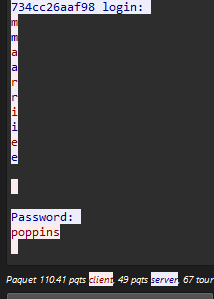  
On remarque que lorsque l’utilisateur saisit son nom d’utilisateur, le serveur renvoie les caractères en écho pour les afficher sur le terminal. En revanche, le mot de passe est masqué.    


# Automatisation de l'extraction des identifiants via Python

In [ ]:
from scapy.all import *


# Variables globales pour un buffer.
buffer = bytearray()

def extractID(line):
    line = line.replace(b'\x00', b'')  # On retire les null-bytes qui peuvent poser problème au décodage.
    line = line.strip()  # On nettoie les caractères invisibles tels que les retours chariot "\r" et les sauts de ligne "\n"
    line = line.decode('utf-8', errors='ignore')
    if "login: " in line and "Last login: " not in line:  # On sélectionne les messages contenant "login: ", mais on exclut le MOTD ("Last login: <date> from <IP> on <terminal>")
        username = line.split("login: ")[1]  # On extrait le texte après "login: "
        username2 = ""
        for i in range(1, len(username), 2):  # On retire un caractère sur deux (à cause de l'écho)
            username2 += username[i]
        print(f"Le nom d'utilisateur est : {username2}")
    elif "Password: " in line:  # On sélectionne les messages contenant "Password: "
        password = line.split("Password: ")[1]
        print(f"Le mot de passe est : {password}")


def findTelnetpacket(trame):
    global buffer
    if trame.haslayer(TCP) and trame.haslayer(Raw):  # On sélectionne seulement les paquets avec une couche TCP et une couche applicative (on exclut les acquittements secs et le début/fin de connexion)
        if trame[TCP].dport == 23 or trame[TCP].sport == 23:  # On sélectionne les paquets qui proviennent ou vont vers le serveur Telnet
            buffer += trame[Raw].load  # On remplit le buffer de données
            if b"\r\n" in buffer:  # Si un retour à la ligne est détecté
                extractID(buffer)
                buffer = bytearray()  # On vide le buffer et on continue.


# Lecture du fichier et boucle principale:
for trame in rdpcap("Capture/telnet-total.pcapng"):
    findTelnetpacket(trame)

# Pour capturer les sessions Telnet en temps réel:
#sniff(filter="tcp", prn=findTelnetpacket)